# Welcome to the tutorial:

**Estimating Individual Differences Relationships with R and STAN!** <br> 
**Part of the 2nd Mental Effort Workshop!** <br>

This tutorial was written by Laura A. Bustamante in 2021 from the Princeton Neuroscience Institute. Much of the code was adapted from scripts provided to me by Nathaniel Daw, Sam Zorowitz, and Daniel Bennet, many thanks to them! Thanks also to the [Daw lab](https://dawlab.princeton.edu/) including Yoel Sanchez-Arujo, Flora Boucercourt, and Ari Khan who generously respond to my #stan slack messages. Thanks also to Jeremy Lee and Ivan Grahek for piloting and giving feedback on this notebook.  
<br><br>
In this tutorial you will learn about directly estimating inter-task or inter-parameter correlations, as well as test-retest correlations. We will use data generously made open source by Eisenberg and colleagues (2019).
<br>
See the [paper](https://www.nature.com/articles/s41467-019-10301-1) and [Github repository](https://github.com/IanEisenberg/Self_Regulation_Ontology/tree/master/Data/Complete_02-16-2019/Individual_Measures) for complete information. 

**About the Code in this Notebook** <br>
The following code is R language and heavily leverages the package [dplyr](https://www.rstudio.com/wp-content/uploads/2015/02/data-wrangling-cheatsheet.pdf), click to see cool cheatsheets for the commands. Hopefully you have either had some experiences with these, or they will be intutive enough to follow along. The exercises in this notebook will focus on tweaking the code so you should be able to follow along even if you don't understand how every line works in the notebook. To help put you in a *cool coders mindset* remember to Google! Once you've fumbled on a piece of code for more than a minute go ahead and Google what you're trying to do, an easy format for the search 1) the code language, and 2) the desired operation (i.e. r lang take group average). This Colaboratory notebook even has a tool to efficently search StackOverflow for error messages you'll get.
<br> In the next few code boxes you are going to install and load the necesary packages. Note that the first box should only be run once. You can comment the cell out after you run it by typing 'command' and '/' at once. 
<br> This first package allows us to [run R code in a Jupyter notebook](https://towardsdatascience.com/how-to-use-r-in-google-colab-b6e02d736497) which typically used with python. Indeed in this notebook you could mix Python and R code. Every cell you run will need to have 
```
%%R 
```
at the start otherwise it will be looking for python code. Keep in mind the first error you might get when you make a code cell is forgetting to put this! 

In [1]:
# load rpy2 which lets us run r code in a jupyter notebook
# https://towardsdatascience.com/how-to-use-r-in-google-colab-b6e02d736497
# might need to run.. 
# pip install rpy2
%load_ext rpy2.ipython

**The Problem:** 
<br>
Imagine that you are interested in understanding how behavior in two or more cognitive tasks are related, for example would a participant who is more risky in a gambling task also more impatient in a task involving delayed rewards? Or another example, does a participant who has higher accuracy in a visual working memory task also have a higher accuracy on an auditory working memory test? Typically any of these tasks will have some sort of scoring system or regression model for analyzing the data and generating a summary statistic for each participant. To compare across measures often researchers will use a correlation using the summary statistics from each task per participant as the data. In our first example each participant may have computed one quantity representing their risk tolerance, and one quantity representing their delay discounting steepness, and the researcher would use a correlation or simple linear regression to measure the strength of the relationship between these quantities. But, participants often complete tens or hundreds of trials each of which contributed to that single estimate. So by taking this startegy we actually lose this fine grained information. Especially important is the fine grained information about how uncertain the parameter estimate is. To consider this issue imagine that in the tasks a subset of participants closed their eyes and pressed keys randomly for much of the experiment. In this case our statitical models specially tuned to the options of the experiment won't be a good fit to the data. The model that generated the summary estimate had that information and would have a high score of uncertainty for such a participant. When the researcher would go to correlate the two tasks, ideally the correlation shouldn't be strongly biased by the datapoints that are particularly uncertain (i.e. the inattentive participant). And the good news is... hierarchal models can do the mathemagic to estimate a correlation taking into account the uncertainty in the participant level metrics! Today you'll learn how to harness this very sheek, probably beneficial, and respectably challenging method for your very own deep questions about human nature. 

# Tutorial goals
1. Understand the components of a .stan script. 
<br>
2. Be able to format data for use in STAN 
<br>
3. Be able to modify STAN code in important ways 
<br> 
4. Understand the outputs of a STAN model and be able to analyze the model for results

**The Dataset** 
<br> Eisenberg & colleages (2019) completed a massive online study of a battery of behavioral task and self-report measures of 'Self-regulation' (ie. risk-taking, temporal discounting and impulsivity, working memory, information processing, learning). They recruited 522 participants from Amazon Mechanical Turk. Every participant completed 37 tasks and 22 self-report surveys. In this tutorial we will focus on two of the behavioral tasks administered; the Two-step reinforcement learning task (Daw et al. 2011), and a delay discounting task (Kirby & Maraković, 1996). We will create a hierarchal bayesian model that estimates the parameters of each task, as well as the inter-parameter correlations.

In [2]:
%%R
# run this block only once at set up 
# some packages don't come pre-installed in Colab and you will have to install them
# if theres any package that you don't have, you can simply use this code: 
# install.packages("insert_package_name")
install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
library(cmdstanr)
install_cmdstan()
check_cmdstan_toolchain()
install.packages("posterior")
install.packages("bayesplot")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘numDeriv’, ‘abind’, ‘tensorA’, ‘distributional’, ‘checkmate’, ‘posterior’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/numDeriv_2016.8-1.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 76053 bytes (74 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

cp bin/linux-stanc bin/stanc
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include   -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_5.7.0/include    -DBOOST_DISABLE_ASSERTS         -c -fvisibility=hidden -o bin/cmdstan/stansummary.o src/cmdstan/stansummary.cpp
chmod +x bin/stanc
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include   -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_5.7.0/include    -DBOOST_DISABLE_ASSERTS         -c -fvisibility=hidden -o bin/cmdstan/print.o src/cmdstan/print.cpp
g++ -std=c++1y -pthread -D_REENTRANT -Wn

R[write to console]: * Finished installing CmdStan to /root/.cmdstanr/cmdstan-2.27.0


R[write to console]: CmdStan path set to: /root/.cmdstanr/cmdstan-2.27.0

R[write to console]: The C++ toolchain required for CmdStan is setup properly!



In [10]:
%%R
# Load packages 
library(tidyr)
library(tidyverse)
library(magrittr)
library(data.table)
library(dplyr)
library(ggplot2)
library(bayesplot)
library(cmdstanr)
library(posterior)

R[write to console]: This is bayesplot version 1.8.1

R[write to console]: - Online documentation and vignettes at mc-stan.org/bayesplot

R[write to console]: - bayesplot theme set to bayesplot::theme_default()

R[write to console]:    * Does _not_ affect other ggplot2 plots

R[write to console]:    * See ?bayesplot_theme_set for details on theme setting

R[write to console]: This is posterior version 1.0.1

R[write to console]: 
Attaching package: ‘posterior’


R[write to console]: The following object is masked from ‘package:bayesplot’:

    rhat


R[write to console]: The following objects are masked from ‘package:stats’:

    mad, sd, var




# The Tasks
We are going to choose two tasks that I am familiar with in my dissertation research on the stability of measurement of the cost of cognitive control across different decision task styles. In the Eisenberg paper they focus on constructs related to 'self regulation'. The tasks we will use in this tutorial are the Two Step task, a very popular task to measure model-free versus model-based reinforcement learning strategies, and an Inter-temporal Choice Task (ITC) which measures individual differences in delay discounting. In terms of self-regulation a simple prediction would be that people who have more model-based relative to model-free strategy have greater self-regulation, as well as people who chose larger rewards later more often (smaller delay discounting parameter). Therefore, we can predict that across participants model-based and delay discounting parameters will be negatively correlated, and perhaps model-free will be positively correlated with delay discounting. If these predictions don't quite make sense, we'll dive deeper into the tasks next!

# The Two-step Task
measures reinforment learning stategy in a two armed bandit game. It measures the degree to which you learn rewards using a model of the sequences of events that lead to rewards, vs you repeat previously rewarded actions independent of a model of the environment.
<br>
(direct quote from the [Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-10301-1/MediaObjects/41467_2019_10301_MOESM1_ESM.pdf)) Participants made two sequential decisions between abstract shapes overlaid on different colored backgrounds. The first decision (Stage 1) between the two abstract shapes lead to one of two second "stages" (Stage 2 or Stage 3) where the participants made a second decision between two shapes. The decision in the second phase resulted in either winning a coin or not. Participants’ goal was to win as many coins as possible. They were told that each shape in the first stage was more likely to lead to one second stage than the other and that these probabilities remain the same across the task. They were also told that the probabilities of winning a coin from choosing either shape in the second stage changed across the task. Participants completed 50 practice trials and 200 test trials. Total points on this task contributed to the final bonus payment. Importantly, the task was structured such that each first-step decision lead to one second-stage (set of 2 shapes) frequently (70% of the time), and the other second-stage infrequently (30%). For instance, one shape in Stage 1 lead to Stage 2 frequently and Stage 3 infrequently. This task structure was stable throughout the experiment. On the other hand, reward probabilities associated with the Stage 2 and 3 shapes adjusted gradually and continuously over the experiment, to incentivize continued learning. Thus to perform optimally at the task, a participant must learn the transition probabilities at the first stage, and use them combined with trial-by-trial updates of reward probabilities to make optimal decisions.
Three DVs were calculated based on the following logistic regression: 
<br>
Equation 2
```
P(stay) ~ feedback(t−1) * transition(t−1)
```
That is, the probability of making the same choice at t was modeled as a function of the interaction between feedback at t-1 and the transition (frequent or infrequent) at t-1. A "model-free" index was calculated as the main effect of feedback, a "model-based" index was calculated as the interaction between feedback and transition, and a "perseverance" index was the intercept of the model. We used mixed-effects logistic regression using the lme4 R package with the full interactive model fit as a random effect across participants. Individual DVs were defined based on these random effects.

**Let's have a look at the data** 

In [11]:
%%R
# Load the data 
TwoStep_con <- gzcon(url("https://github.com/IanEisenberg/Self_Regulation_Ontology/blob/master/Data/Complete_02-16-2019/Individual_Measures/two_stage_decision.csv.gz?raw=true"))
TwoStep_txt <- readLines(TwoStep_con)
TwoStep_data_full <- read.csv(textConnection(TwoStep_txt))
head(TwoStep_data_full,10)
names(TwoStep_data_full)

 [1] "X"                     "FB_probs"              "battery_name"         
 [4] "exp_stage"             "experiment_exp_id"     "feedback"             
 [7] "feedback_last"         "finishtime"            "focus_shifts"         
[10] "full_screen"           "key_press_first"       "key_press_second"     
[13] "passed_check"          "possible_responses"    "rt_first"             
[16] "rt_second"             "stage"                 "stage_second"         
[19] "stage_transition"      "stage_transition_last" "stim_order_first"     
[22] "stim_order_second"     "stim_selected_first"   "stim_selected_second" 
[25] "stimulus"              "switch"                "time_elapsed"         
[28] "trial_id"              "trial_num"             "trial_type"           
[31] "worker_id"            


**Tidying Two-step data**
The columns we will use here are 'stay_twostep' = 1 when participants repeat the first stage choice, and 0 when participants switch the first stage choice. This is the main dependent measure and will be used in a logistic regression model. The predictor variables are whether or not the previous second stage choice was rewarded (reward_twostep = 1 rewarded, -1 unrewarded), whether the transition was common or uncommon (transition_twostep = 1 if common -1 if uncommon), and an interaction term reward_twostep * transition_twostep. The model-free parameter is the beta value of just the reward_twostep. You can think of the particiant repeating a choice just because it was previously rewarded. The model-based parameter is the beta value of the interaction reward_twostep * transition_twostep. You can think of the participant repeating the previous choice when they were rewarded and it was a common transition. The model also includes an intercept and a beta value for the effect of transition (regardless of reward).

In [12]:
%%R
# Tidying Two-step data
TwoStep_data <- TwoStep_data_full %>%
  filter(exp_stage == "test",
  # adjust for missed trials, which don't have 'feedback_last'
  !is.na(feedback_last)) %>%
  select(worker_id,
  stage,
  switch,
  feedback,
  feedback_last,
  stage_transition,
  stage_transition_last) %>%
  # uncomment if you want to inspect the original data 
  # %T>% print() %>%
  transmute(worker_id,
        # stay or repeat first stage choice = 1, switch = 0
        stay_twostep = ifelse(switch == 'False', 1, 0),
        # rewarded on previous second stage trial = 1, not rewarded = -1
        reward_twostep = ifelse(feedback_last == 1, 1, -1),
        # common transition on previous trial = 1, uncommon = -1
        transition_twostep = ifelse(stage_transition_last == "frequent", 1, -1))

# Have a look 
head(TwoStep_data, 25)

   worker_id stay_twostep reward_twostep transition_twostep
1       s001            0              1                  1
2       s001            0             -1                  1
3       s001            1              1                 -1
4       s001            1             -1                  1
5       s001            0             -1                  1
6       s001            1              1                  1
7       s001            0              1                  1
8       s001            1             -1                  1
9       s001            0             -1                  1
10      s001            0             -1                  1
11      s001            1              1                  1
12      s001            0              1                  1
13      s001            1             -1                  1
14      s001            1              1                  1
15      s001            1             -1                 -1
16      s001            0             -1

First things first, let's look at some simple metrics for this task. You always want to get to know your data and what kind of numbers you can expect before you head into the modelling. Below is code that, for each participant, calculates the mean number of times they repeated their first stage choice when they did versus did not recieve reward in the previous trial (second stage). Then it creates a histogram of these by participant values.

`summarise()` has grouped output by 'reward_twostep'. You can override using the `.groups` argument.
# A tibble: 1,044 × 3
# Groups:   reward_twostep [2]
   reward_twostep worker_id stay_mean
            <dbl> <chr>         <dbl>
 1             -1 s001          0.490
 2             -1 s002          0.473
 3             -1 s003          0.657
 4             -1 s004          0.566
 5             -1 s005          0.878
 6             -1 s006          0.531
 7             -1 s007          0.5  
 8             -1 s008          0.628
 9             -1 s009          0.621
10             -1 s010          0.486
# … with 1,034 more rows


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



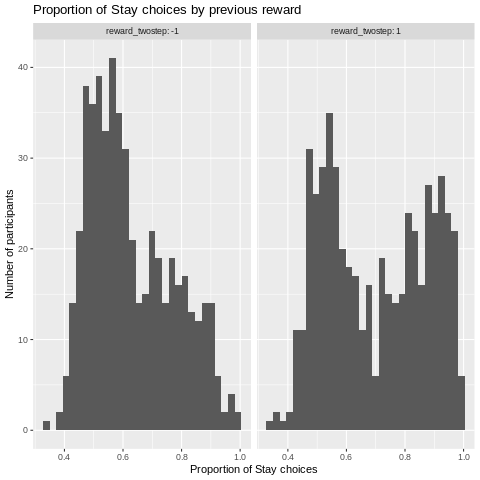

In [13]:
%%R
stay_reward_twostep <- TwoStep_data %>%
  group_by(reward_twostep,
           worker_id) %>%
  summarise(stay_mean = mean(stay_twostep, na.rm = TRUE)) %T>% 
  print()

ggplot(data = stay_reward_twostep,
      aes(x = stay_mean)) + 
      geom_histogram() + 
      facet_grid(~ reward_twostep,
                labeller = label_both) + 
      labs(title = "Proportion of Stay choices by previous reward",
           x = "Proportion of Stay choices",
           y = "Number of participants")

# Exercise 1
<br>
Modify the code to calculate the probability of staying after participants experienced a common versus uncommon transition on the previous trial, *as well as* by rewarded versus unrewarded. All combinations of these independent variables make for four numbers per participant. Once you have this, check out the individual differences by making four histograms.
<br> The value for staying after a previously rewarded uncommon transition is related to the model-free parameter. The value for staying after a previously rewarded common transition is related to the model-based parameter. 

In [ ]:
%%R
# Exercise 1 Solution here

Good job! Next we are going to calculate the group average and standard error of the mean and plot it for all four conditions. This plot is a very common way to see the mixture of model-based and model-free contributions to behavior.

`summarise()` has grouped output by 'reward_twostep', 'transition_twostep'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'reward_twostep'. You can override using the `.groups` argument.
# A tibble: 4 × 4
# Groups:   reward_twostep [2]
  reward_twostep transition_twostep stay_mean stay_sem
  <fct>          <fct>                  <dbl>    <dbl>
1 -1             -1                     0.646  0.00772
2 -1             1                      0.622  0.00620
3 1              -1                     0.672  0.00812
4 1              1                      0.713  0.00800


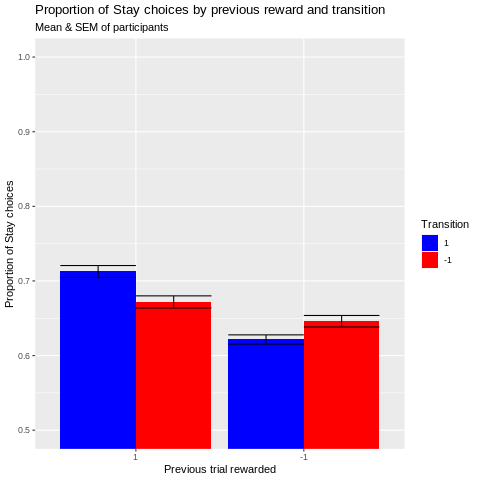

In [14]:
%%R
nsubj <- length(unique(TwoStep_data$worker_id))

stay_reward_transition_twostep_group <- TwoStep_data %>%
  group_by(reward_twostep,
          transition_twostep,
          worker_id) %>%
  summarise(Stay_mean = mean(stay_twostep, na.rm = TRUE)) %>% 
  summarise(stay_mean = mean(Stay_mean, na.rm = TRUE),
            stay_sem = sd(Stay_mean, na.rm = TRUE)/sqrt(nsubj)) %>%
  mutate(reward_twostep = factor(reward_twostep, 
                                 levels = c("1", "-1")),
         transition_twostep = factor(transition_twostep, 
                                 levels = c("1", "-1"))) %T>% 
  print()

  ggplot(data = stay_reward_transition_twostep_group,
      aes(x = reward_twostep, 
          y = stay_mean,
          fill = transition_twostep,
          group = transition_twostep)) + 
      geom_bar(stat = "identity",
               position = "dodge") + 
      geom_errorbar(aes(ymin = stay_mean - stay_sem,
                    ymax = stay_mean + stay_sem,
                    group = transition_twostep),
                    position = "dodge") + 
      labs(title = "Proportion of Stay choices by previous reward and transition",
           subtitle = "Mean & SEM of participants",
           y = "Proportion of Stay choices",
           x = "Previous trial rewarded",
           fill = "Transition") + 
      scale_fill_manual(values = c("1" = "blue", "-1" = "red")) + 
      coord_cartesian(ylim = c(0.5, 1))


Compare this plot to Figure 2 from the original Two-step paper (Daw et al. 2011). Do you understand these predictions? It seems like the data from this study has the same pattern as panel C below. This is a good data quality check!

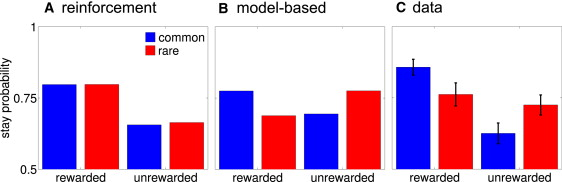

[Figure 2.](https://www.sciencedirect.com/science/article/pii/S0896627311001255#fig2) Factorial Analysis of Choice Behavior

(A) Simple reinforcement predicts that a first-stage choice resulting in reward is more likely to be repeated on the subsequent trial, regardless of whether that reward occurred after a common or rare transition.

(B) Model-based prospective evaluation instead predicts that a rare transition should affect the value of the other first-stage option, leading to a predicted interaction between the factors of reward and transition probability.

(C) Actual stay proportions, averaged across subjects, display hallmarks of both strategies. Error bars: 1 SEM.

# Intertemporal Choice Task

**Inter-temporal Choice Task (ITC):** 
<br>
**Delay Discounting Titrator Version**
<br>
(direct quote from the [Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-10301-1/MediaObjects/41467_2019_10301_MOESM1_ESM.pdf), description on [Science of Behavioral Change](https://scienceofbehaviorchange.org/measures/intertemporal-choice-task-with-discount-titrating/))<br> 
In this task, participants chose between a sooner-smaller monetary amount and a larger-later one... The sooner reward can be immediate or delayed two weeks. The later reward can be either two or four weeks later than the sooner reward. The sooner amounts were drawn from a normal distribution with a mean of 20 and standard deviation of 10, clipped at 5 and 40. The relative difference between the sooner and later reward can be 1, 5, 10, 15, 20, 25, 30, 50, 75% higher. Participants made 36 choices. One random trial was chosen and contributed to the total bonus the participant received (note: the receipt of this bonus was not linked to their chosen delay in any way). Behavior from this task was evaluated by both tallying the number of patient choices across all trials and fitting a hyperbolic model to the choices where the subjective value of the delayed amount decreases according to the following function:<br>
```
discounted value = amount/1+discount_k x delay
# for example:
larger later value = larger later amount/1+discount_k x larger later delay
```
*Quick mental exercise*, what is the discounted value of an option when discount_k parameter is 0? and when it is 1? Feel free to note your answer down in this notebook. 

**Let's have a look at the ITC data**

In [15]:
%%R
# Load the data, here can get direct from the project github
ITC_con <- gzcon(url("https://github.com/IanEisenberg/Self_Regulation_Ontology/blob/master/Data/Complete_02-16-2019/Individual_Measures/discount_titrate.csv.gz?raw=true"))
ITC_txt <- readLines(ITC_con)
ITC_data_full <- read.csv(textConnection(ITC_txt))
head(ITC_data_full, 10)
names(ITC_data_full)

 [1] "X"                   "battery_name"        "choice"             
 [4] "chosen_amount"       "chosen_delay"        "credit_var"         
 [7] "exp_stage"           "experiment_exp_id"   "finishtime"         
[10] "focus_shifts"        "full_screen"         "indiff_k"           
[13] "key_press"           "larger_amount"       "later_days"         
[16] "later_delay"         "now1_notnow0"        "patient1_impatient0"
[19] "performance_var"     "possible_responses"  "rel_diff"           
[22] "responses"           "rt"                  "smaller_amount"     
[25] "sooner_days"         "sooner_delay"        "stimulus"           
[28] "text"                "time_elapsed"        "trial_id"           
[31] "trial_type"          "worker_id"          


**Tidying up the intertemporal choice data**
<br>
In the code below, we are going to tidy up the data, we will first filter out all the rows that weren't part of the main task (practice etc.). Then we will select the columns that we need for our analysis and rename them etc.<br>
The columns are the participant identifier (worker_id), the choice the participant made on each trial SSchoice_itc (choose smaller sooner option = 1, larger later = 0), and the value of both options SS_itc (smaller sooner amount, dollars), SS_Delay_ITC (smaller sooner delay, days), LL_itc (larger later amount, dollars), LL_Delay_ITC (larger later delay, days). Note in the data pre-processing that we scaling the delays down for the model by dividing them by 7 (so now they become weeks). This is for the STAN model and will be explained later in the notebook.
 

In [16]:
%%R
# Tidy the data 
ITC_data <- ITC_data_full %>%
  filter(trial_id == "stim") %>%
  select(choice,
  patient1_impatient0,
  smaller_amount,
  sooner_days,
  sooner_delay,
  larger_amount,
  later_days,
  later_delay,
  trial_id,
  worker_id) %>%
  # uncomment if you want to inspect the original data 
  # %T>% print() %>%
  transmute(worker_id,
  # choose smaller sooner option = 1, larger later = 0
  SSchoice_itc = patient1_impatient0,
  # smaller sooner amount (dollars)
  SS_itc = smaller_amount/10,
  # smaller sooner delay (days)
  SS_Delay_itc = sooner_days/7,
  # larger later amount (dollars)
  LL_itc = larger_amount/10,
  # larger later delay (days)
  LL_Delay_itc = later_days/7)
# Have a look 
head(ITC_data, 25)

   worker_id SSchoice_itc SS_itc SS_Delay_itc LL_itc LL_Delay_itc
1       s001            0  2.058            0  2.593            2
2       s001            0  2.166            0  2.274            2
3       s001            0  3.053            0  3.358            2
4       s001            0  0.557            0  0.696            2
5       s001            1  0.500            2  0.505            6
6       s001            0  2.480            0  2.852            2
7       s001            0  0.500            0  0.525            4
8       s001            0  3.582            2  3.940            6
9       s001            0  1.807            0  1.825            4
10      s001            0  0.731            0  0.914            4
11      s001            0  1.435            0  1.722            4
12      s001            0  2.360            0  2.384            2
13      s001            0  2.423            0  3.150            2
14      s001            0  2.143            2  2.572            6
15      s0

To get a better sense of the independent variables (the choice options offered), we will make histograms of them all below.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



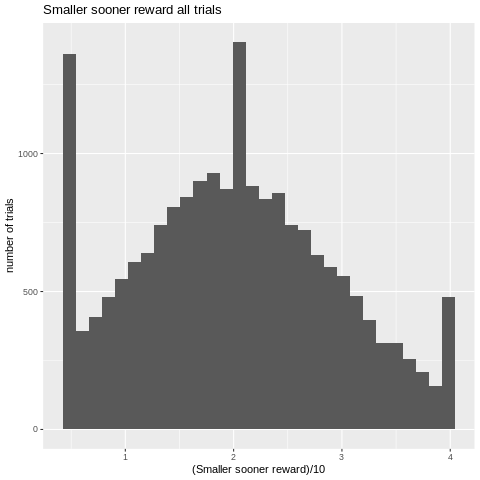

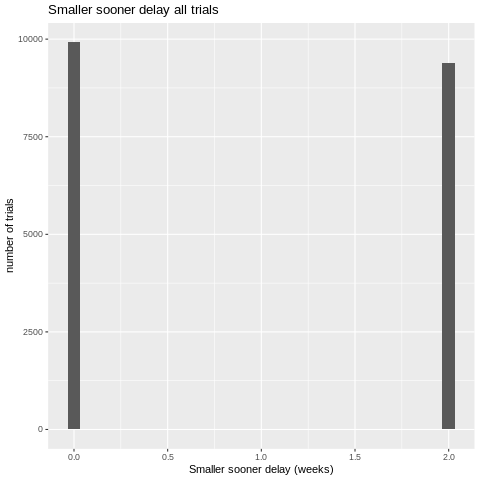

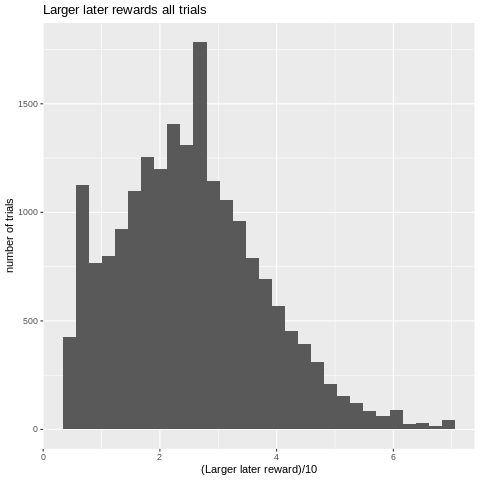

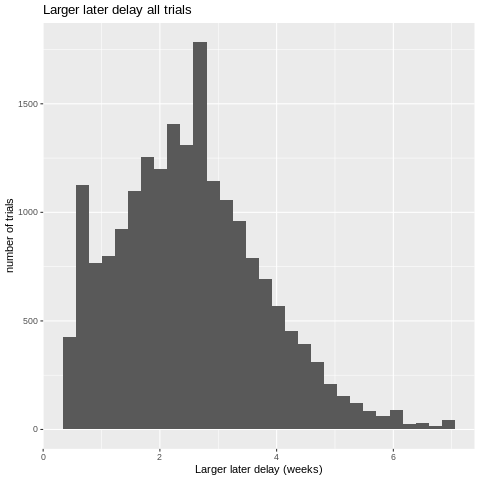

In [17]:
%%R
print(ggplot(data = ITC_data,
       aes(x = SS_itc)) + 
       geom_histogram() + 
       labs(title = "Smaller sooner reward all trials",
            y = "number of trials",
            x = "(Smaller sooner reward)/10"))
print(ggplot(data = ITC_data,
       aes(x = SS_Delay_itc)) + 
       geom_histogram() + 
       labs(title = "Smaller sooner delay all trials",
            y = "number of trials",
            x = "Smaller sooner delay (weeks)"))
print(ggplot(data = ITC_data,
       aes(x = LL_itc)) + 
       geom_histogram() + 
       labs(title = "Larger later rewards all trials",
            y = "number of trials",
            x = "(Larger later reward)/10"))
print(ggplot(data = ITC_data,
       aes(x = LL_itc)) + 
       geom_histogram() + 
       labs(title = "Larger later delay all trials",
            y = "number of trials",
            x = "Larger later delay (weeks)"))

# Exercise 2
Let's look a metrics for this task. For each participant calculate the mean number of times they made a smaller sooner choice. Averaged across all of the options, this could reflect something like how impatient (higher proportion of smaller sooner choice) each participant is.
<br> 
Once you have this, make a histogram of participants. 

In [ ]:
%%R
# Exercise 2 answer here


# Preparing the data for STAN
Next, we will prepare the data for STAN. STAN is a probabalistic programming language that allows for the fitting of Bayesian models. **What distinguishes STAN from a standard regression models (i.e. mixed-effects regression) is that the regressors are fully customizable and can include things like multiplications/divisions, and subtractions of parameters.** There are many ways to run a STAN script (ie. from R with cmdstanr or rstan packages, or from python with cmdstanpy). Today we will use R, but the same .stan script will work regardless of what compatible program you run it from. STAN will always be taking in a list. The data that our STAN model 'TwoStep_ITC_covar.stan' will require is: 

In [7]:
%%R
# load and inspect the STAN model 
# retrieve from github
TwoStep_ITC_covar_stan_URL <- url("https://github.com/laurabustamante/individual_differences_analysis_stan/blob/main/TwoStep_ITC_covar.stan?raw=true")
TwoStep_ITC_covar_stan_txt <- readLines(TwoStep_ITC_covar_stan_URL)
TwoStep_ITC_covar_stan_tmpf <- write_stan_file(TwoStep_ITC_covar_stan_txt)
TwoStep_ITC_covar_model <- cmdstan_model(TwoStep_ITC_covar_stan_tmpf)
# inspect
TwoStep_ITC_covar_model$print()

# if you can to upload the .stan model yourself
# setwd(/your_dir/)
# file <- file.path("TwoStep_ITC_covar.stan")
# TwoStep_ITC_covar_model <- cmdstan_model(file)
# TwoStep_ITC_covar_model$print()

R[write to console]: Compiling Stan program...



Classes 'CmdStanModel', 'R6' <CmdStanModel>
  Public:
    check_syntax: function (pedantic = FALSE, include_paths = NULL, stanc_options = list(), 
    clone: function (deep = FALSE) 
    code: function () 
    compile: function (quiet = TRUE, dir = NULL, pedantic = FALSE, include_paths = NULL, 
    cpp_options: function () 
    exe_file: function (path = NULL) 
    generate_quantities: function (fitted_params, data = NULL, seed = NULL, output_dir = NULL, 
    hpp_file: function () 
    initialize: function (stan_file, compile, ...) 
    model_name: function () 
    optimize: function (data = NULL, seed = NULL, refresh = NULL, init = NULL, 
    print: function () 
    sample: function (data = NULL, seed = NULL, refresh = NULL, init = NULL, 
    sample_mpi: function (data = NULL, mpi_cmd = "mpiexec", mpi_args = NULL, 
    save_hpp_file: function (dir = NULL) 
    stan_file: function () 
    variational: function (data = NULL, seed = NULL, refresh = NULL, init = NULL, 
  Private:
    cpp_

The code has a few parts. In the data{...} section is where you upload the data and define the data types. Here we use integers (int) and matrices (matrix[nrow,ncol]). Since this STAN model is already written for you, take some time to examine the data block; in the next section we are going to move from a .csv upload of the data, into a data format suitable for STAN programs. 


```
data {
	// number of subjects
	int NS_all; 
	
	// two-step vars 
	int NS_twostep;
	int MT_twostep;
	int NT_twostep[NS_twostep];
	// stay & repeat first stage choice = 1, switch = 0
	int stay_twostep[NS_twostep,MT_twostep]; 
	// rewarded on previous second stage trial = 1, unrewarded = -1 
	matrix[NS_twostep,MT_twostep] reward_twostep;  
	// common transition on previous trial = 1, uncommon = -1
	matrix[NS_twostep,MT_twostep] transition_twostep; 
	
	// ITC vars 
	int NS_itc;
	int MT_itc;
	int NT_itc[NS_itc];
	int SSchoice_itc[NS_itc,MT_itc];
	matrix[NS_itc,MT_itc] SS_itc;  
	matrix[NS_itc,MT_itc] SS_Delay_itc;  
	matrix[NS_itc,MT_itc] LL_itc;
	matrix[NS_itc,MT_itc] LL_Delay_itc;
}
```

We will return to the other code chunks of the STAN model later in the notebook. Below is an example of how to get your data into a list suitable for STAN. There are many ways this can be accomplished given your prefered coding style or skillset! ***The main thing is that you have to make a list containing all of the data specified in the STAN model, and the data has to be of the type of declared in the STAN model.***

In [19]:
%%R
# This code is built to also accomodate datasets in which not all participants
# completed all the measures in the battery (not the case for this dataset)
NS_twostep <- length(unique(TwoStep_data$worker_id))
NS_itc <- length(unique(ITC_data$worker_id))
NS_all <- max(NS_twostep, NS_itc) %T>% 
          print()

# Create a dataframe subs_all that says which tasks a participant completed         
subs_twostep <- unique(TwoStep_data$worker_id)
subs_itc <- unique(ITC_data$worker_id)
all_subs <- bind_rows(as.data.frame(subs_itc) %>% 
                      rename(worker_id = subs_itc), 
                      as.data.frame(subs_twostep) %>% 
                      rename(worker_id = subs_twostep)) %>% 
  distinct() %>%
  mutate(sub_twostep = 0,
         sub_itc = 0)
  
for (r in 1:nrow(all_subs)){
  tmp_sub <- slice(all_subs, r)$worker_id
  if (tmp_sub %in% subs_itc){
    all_subs <- all_subs %>%
      mutate(sub_itc = ifelse(worker_id == tmp_sub, 
                              1, sub_itc))
  }
  if (tmp_sub %in% subs_twostep){
    all_subs <- all_subs %>%
      mutate(sub_twostep = ifelse(worker_id == tmp_sub, 
                              1, sub_twostep))
  }
}
subs_all <- all_subs 
# Print
subs_all %>% 
  head(., 15)

[1] 522
   worker_id sub_twostep sub_itc
1       s001           1       1
2       s002           1       1
3       s003           1       1
4       s004           1       1
5       s005           1       1
6       s006           1       1
7       s007           1       1
8       s008           1       1
9       s009           1       1
10      s010           1       1
11      s011           1       1
12      s012           1       1
13      s013           1       1
14      s014           1       1
15      s015           1       1


In [20]:
%%R
# This code is also built to also accomodate datasets in which participants
# have different numbers of trials (in this case, missed two-step trials) 
NT_twostep <- TwoStep_data %>%
  group_by(worker_id) %>%
  tally() %>%
  rename(NT_twostep = n)

NT_itc <- ITC_data %>%
  group_by(worker_id) %>%
  tally() %>%
  rename(NT_itc = n)

NT <- full_join(NT_twostep,
  NT_itc, by = "worker_id") %>%
  mutate(NT_twostep = ifelse(is.na(NT_twostep), 0, NT_twostep),
         NT_itc = ifelse(is.na(NT_itc), 0, NT_itc)) %T>% 
  print()

# A tibble: 522 × 3
   worker_id NT_twostep NT_itc
   <chr>          <int>  <int>
 1 s001             178     37
 2 s002             199     37
 3 s003             192     37
 4 s004             200     37
 5 s005             200     37
 6 s006             197     37
 7 s007             199     37
 8 s008             200     37
 9 s009             200     37
10 s010             199     37
# … with 512 more rows


In [21]:
%%R
######## Initialize Two-Step variables ############

MT_twostep <- max(NT$NT_twostep, na.rm = TRUE)

stay_twostep <- matrix(0,NS_all,MT_twostep)

reward_twostep <- matrix(0,NS_all,MT_twostep)

transition_twostep <- matrix(0,NS_all,MT_twostep)

####### Initialize Intertemporal choice variables ####### 

MT_itc <- max(NT$NT_itc, na.rm = TRUE)

SSchoice_itc <- matrix(0,NS_all,MT_itc) 

SS_itc <- matrix(0,NS_all,MT_itc)

SS_Delay_itc <- matrix(0,NS_all,MT_itc)

LL_itc <- matrix(0,NS_all,MT_itc)

LL_Delay_itc <- matrix(0,NS_all,MT_itc)

In [22]:
%%R
# Loop through participants
for (i in 1:NS_all) {
  tmp_sub <- subs_all$worker_id[i]
  # only add data if this participant did two step task 
  if (filter(subs_all, worker_id == tmp_sub)$sub_twostep == 1){
    
        stay_twostep[i,1:NT$NT_twostep[i]] = subset(TwoStep_data,worker_id==tmp_sub)$stay_twostep;

        reward_twostep[i,1:NT$NT_twostep[i]] = subset(TwoStep_data,worker_id==tmp_sub)$reward_twostep;
        
        transition_twostep[i,1:NT$NT_twostep[i]] = subset(TwoStep_data,worker_id==tmp_sub)$transition_twostep;
  }
  # only add data if this participant did two step task 
  if (filter(subs_all, worker_id == tmp_sub)$sub_itc == 1){

        SSchoice_itc[i,1:NT$NT_itc[i]] = subset(ITC_data,worker_id==tmp_sub)$SSchoice_itc;

        SS_itc[i,1:NT$NT_itc[i]] = subset(ITC_data,worker_id==tmp_sub)$SS_itc;
        # to do might want to scale the SS_itc and LL_itc
        SS_Delay_itc[i,1:NT$NT_itc[i]] = subset(ITC_data,worker_id==tmp_sub)$SS_Delay_itc;

        LL_itc[i,1:NT$NT_itc[i]] = subset(ITC_data,worker_id==tmp_sub)$LL_itc;
        
        LL_Delay_itc[i,1:NT$NT_itc[i]] = subset(ITC_data,worker_id==tmp_sub)$LL_Delay_itc;
  }
}

In [23]:
%%R
stan_data_twostep_itc <- list(NS_all = NS_all,
                              NS_twostep = NS_twostep,
                              MT_twostep = MT_twostep, 
                              NT_twostep = NT$NT_twostep,
                              stay_twostep = stay_twostep, 
                              reward_twostep = reward_twostep, 
                              transition_twostep = transition_twostep,
                              NS_itc = NS_itc,
                              MT_itc = MT_itc,
                              NT_itc = NT$NT_itc,
                              SSchoice_itc = SSchoice_itc,
                              SS_itc = SS_itc,
                              SS_Delay_itc = SS_Delay_itc,
                              LL_itc = LL_itc,
                              LL_Delay_itc = LL_Delay_itc)
# inspect 
str(stan_data_twostep_itc)

List of 15
 $ NS_all            : int 522
 $ NS_twostep        : int 522
 $ MT_twostep        : int 200
 $ NT_twostep        : int [1:522] 178 199 192 200 200 197 199 200 200 199 ...
 $ stay_twostep      : num [1:522, 1:200] 0 1 0 1 0 0 1 1 1 1 ...
 $ reward_twostep    : num [1:522, 1:200] 1 -1 -1 1 1 1 1 -1 -1 -1 ...
 $ transition_twostep: num [1:522, 1:200] 1 1 -1 -1 -1 -1 1 -1 1 1 ...
 $ NS_itc            : int 522
 $ MT_itc            : int 37
 $ NT_itc            : int [1:522] 37 37 37 37 37 37 37 37 37 37 ...
 $ SSchoice_itc      : num [1:522, 1:37] 0 0 1 0 0 1 0 0 1 1 ...
 $ SS_itc            : num [1:522, 1:37] 2.06 2.06 2.06 2.06 2.06 ...
 $ SS_Delay_itc      : num [1:522, 1:37] 0 0 0 0 0 0 0 0 0 0 ...
 $ LL_itc            : num [1:522, 1:37] 2.59 2.59 2.59 2.59 2.59 ...
 $ LL_Delay_itc      : num [1:522, 1:37] 2 2 2 2 2 2 2 2 2 2 ...


# Understanding the STAN model code
Hooray! We have the data in a list, with each entry being of the type (int or matrix) specified in the STAN model. Now let's have a look at the rest of the model code. You can use this command to inspect the model yourself, it will also be listed in the explanation below.

```
TwoStep_ITC_covar_model$print()
```

You've already inspected the data{} chunk so next is parameters{}. In the parameters{} chunk we create a vector of betas; you can think of these just as you would think of betas in a regression model. If you are familiar with mixed-effects regression, you can think of 'beta_ms' as the fixed effects, and 'beta_s' as the random effects. If you aren't too familiar with that no worries, the 'beta_ms' fit a group-level mean and the 'beta_s' is the partcipant-level parameters. This is called a hierarchal model and it means that the participants are drawn from a normal distribution reflecting the group (beta_ms). This can be really helpful if you have outliers with implausible parameters because their parameter will be informed by the rest of the group.

```
parameters {
	// group beta_s
	vector[7] beta_ms; 
	// note parameters will be:
	// beta_s[s][1] = intercept_twostep
	// beta_s[s][2] = model_free_twostep
    // beta_s[s][3] = transition_twostep
    // beta_s[s][4] = model_based_twostep
    // beta_s[s][5] = inv_temp_itc
    // beta_s[s][6] = intercept_itc
    // beta_s[s][7] = discount_k_itc
    
	//per subject beta_s
	vector[7] beta_s[NS_all]; 
	
	// beta_s covariance scale
	vector<lower=0>[7] tau;	
	
	// beta_s covariance correlation 
	corr_matrix[7] omega;    
}
```
The next thing you see in this parameters{} chunk is that we are defining a covariance matrix between the parameters in this model. This would be standard in regression models, but in STAN everything is custom specified so this is optional. We first define 'tau' which reflects the covariances as well as the variances of each parameter, variances must be positive so we set a lower bound of zero '<lower=0>. 
<br>
**Then we define the correlation matrix 'omega' which reflects the correlation between the paramters. This will be our magic sauce for looking at the inter-task correlation!** To complete this covariance matrix we have to use a transformed parameters{} chunk. There are a number of transformations you might want to make here, in our case the creation of the covariance matrix requires a combination of 'omega' and 'tau' accomplished here by initializing a matrix sigma, and then using the command 'quad_form_diag' 
```
transformed parameters {
	// initialize covariance matrix
	matrix[7,7] sigma;
	// define covariance matrix
	sigma = quad_form_diag(omega,tau); 
}
```

Now we get to the best part; **the model block!!** The first thing you need to specify in the model block are the priors. There are a lot of great tutorials on what a prior is and how to select them. The short version for this notebook is that you want to provide some numbers that make sense for the order of magnitude of your parameter. A note about this code in particular is that you have to use the same prior for all of the betas. You can easily make STAN models that have separate parameters and priors. The solution in this method is to scale either your data down (e.g. data_column/10), or scale your beta down (e.g. beta_s[1]/10) if you know that one beta is an order of magnitude differnt than the other. The prior we set here for the covariance matrix 'lkj_corr(1)' is a prior that is neither biased towards the prescense or absense of a correlation. 

```
model {
	// prior on covariance matrix
	omega ~ lkj_corr(1);  	
	// prior on inter-subject variability
	tau ~ normal(0,2); 
	// prior on group level parameter mean 
	beta_ms ~ normal(0,1); 
```
Then we loop through participants and sample their set of 5 beta_s parameters. We do this using a multi-variate normal distribution (arguments to 'multi_normal' are: the beta_ms group mean parameters, the covariance matrix). 
```
	// loop through participants
	for (s in 1:NS_all) {
	  // sample beta_s for this participant 
	  beta_s[s] ~ multi_normal(beta_ms, sigma);
```
Because the code handles missing data, it first checks whether the current participant has any trials at all. 
```
// if this trial is from the two-step task apply two-step model
		if (NT_twostep[s] > 0) {
```
Next we get to the actual model fit to the trial data. Here we are performing logistic regression ('bernoulli_logit') because our dependent variable is binary. On the left hand of the ~ we see the dependent variable indexed by the participant number and trial number. On the right hand of the ~ we see a combining of the beta_s parameters and the data's independent variables. The formula is as described in the description of this task. It is helpful to explicitly write out which beta_ms index corresponds to which parameters and keep this in mind in your analyses
```
// if this trial is from the two-step task apply two-step model
		if (NT_twostep[s] > 0) {
			for (tt in 1:NT_twostep[s]) {
				stay_twostep[s,tt] ~ bernoulli_logit(beta_s[s][1] + 
				beta_s[s][2]*reward_twostep[s,tt] + 
				beta_s[s][3]*transition_twostep[s,tt] +
				beta_s[s][4]*reward_twostep[s,tt]*transition_twostep[s,tt]);
				}
			}
```
So at this point we are still within the for-loop of one participant. All of the two-step trials will have been fit and now comes the ITC. This code block is just like the above, and is quite general for any models you would want to fit with logitic regression.
```		
		// if this trial is from the ITC task apply ITC model
		if (NT_itc[s] > 0) {
			for (ti in 1:NT_itc[s]) {
				SSchoice_itc[s,ti] ~ bernoulli_logit(beta_s[s][5]*(beta_s[s][6] +
				SS_itc[s,ti]/(1+beta_s[s][7]*SS_Delay_itc[s,ti]) +
				LL_itc[s,ti]/(1+beta_s[s][7]*LL_Delay_itc[s,ti])));
				}
		}
	}
}
```
What distinguishes STAN from a standard mixed-effects regression model is that the regressors are fully customizable and can include things like multiplications/divisions, and subtractions of parameters.
<br> 
So now that you understand the STAN file, let's run the model! 

# Fitting the model
We are going to call the model by using $sample(). STAN fits models using Markov Chain Monte Carlo Sampling, and that means it's going to sample a potential parameter space as it tries to get the best possible fit to the data. At the start the model won't have a good sense of the parameters so these samples won't tell us much about the actual values. For this reason we designate some samples as 'warmup' with iter_warmup option, and in this phase the model goes to work finding reasonable parameters. Then we specify how many samples we will take with 'iter_sampling'. Generally here we are trying to balance getting enough samples for the model to converge (rhat = 1) against the extra time it takes to run more samples.<br>
When you are testing your STAN model, you should only run a few samples to save time. Here our first run of the model will be just 150 samples total, whereas a more standard number of samples that I use is 500 warmup and 1,000 samples.

In [24]:
%%R
TwoStep_ITC_covar_fit <- TwoStep_ITC_covar_model$sample(
  data = stan_data_twostep_itc,
  seed = 123,
  chains = 1,
  refresh = 250,
  iter_warmup = 50,
  iter_sampling = 100,
#   to run a full model replace the lines above with these values: 
#   chains = 4,
#   parallel_chains = 4,
#   iter_warmup = 500,
#   iter_sampling = 1000,
  save_warmup = FALSE
)

Running MCMC with 1 chain...

Chain 1 WARNING: There aren't enough warmup iterations to fit the 
Chain 1          three stages of adaptation as currently configured. 
Chain 1          Reducing each adaptation stage to 15%/75%/10% of 
Chain 1          the given number of warmup iterations: 
Chain 1            init_buffer = 7 
Chain 1            adapt_window = 38 
Chain 1            term_buffer = 5 


R[write to console]: Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

R[write to console]: Chain 1 Exception: lkj_corr_lpdf: y is not positive definite. (in '/tmp/RtmpUoO9YO/model-41522eadaa.stan', line 63, column 1 to column 21)

R[write to console]: Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

R[write to console]: Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

R[write to console]: Chain 1 

R[write to console]: Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

R[write to console]: Chain 1 Exception: lkj_corr_lpdf: y is not positive definite. (in '/tmp/RtmpUoO9YO/model-41522eadaa.stan', line 63, column 1 to column 21)

R[write to console]: Chain 1 If this warning occurs sporadically,

Chain 1 Iteration:   1 / 150 [  0%]  (Warmup) 


R[write to console]: Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

R[write to console]: Chain 1 Exception: lkj_corr_lpdf: y is not positive definite. (in '/tmp/RtmpUoO9YO/model-41522eadaa.stan', line 63, column 1 to column 21)

R[write to console]: Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

R[write to console]: Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

R[write to console]: Chain 1 

R[write to console]: Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

R[write to console]: Chain 1 Exception: lkj_corr_lpdf: y is not positive definite. (in '/tmp/RtmpUoO9YO/model-41522eadaa.stan', line 63, column 1 to column 21)

R[write to console]: Chain 1 If this warning occurs sporadically,

Chain 1 Iteration:  51 / 150 [ 34%]  (Sampling) 
Chain 1 Iteration: 150 / 150 [100%]  (Sampling) 
Chain 1 finished in 43.9 seconds.


R[write to console]: 
This may indicate insufficient exploration of the posterior distribution.
Possible remedies include: 
  * Increasing adapt_delta closer to 1 (default is 0.8) 
  * Reparameterizing the model (e.g. using a non-centered parameterization)
  * Using informative or weakly informative prior distributions 




In [ ]:
%%R
# Define variables for analysis and plotting
twostep_itc_fit_vars <- c("intercept_twostep",
                          "model_free_twostep",
                          "transition_twostep",
                          "model_based_twostep",
                          "inv_temp_itc",
                          "intercept_itc",
                          "discount_k_itc")
twostep_itc_fit_vars_titles <- c("intercept, Two-step",
                                 "model-free, Two-step",
                                 "transition, Two-step",
                                 "model-based, Two-step",
                                 "inverse tempurature, ITC",
                                 "intercept, ITC",
                                 "discount k, ITC")

# Analyzing the results

The first thing to know is that the samples are the core information you will need to analyze the results. So, you can get the samples from the STAN model, write them to a csv, and load them into your preffered coding setting.
<br>
That said there are a lot of [cool functions](https://mc-stan.org/cmdstanr/reference/CmdStanMCMC.html) to analyze the model / samples. It's a good idea to learn about these and to extract as much information about the model you'll end up using in your manuscript (i.e. original the model code, model comparison metrics, which STAN version you used). The code I provide will be a mixture of those strategies so that you can see multiple styles.

In the next cell we print out the summary of the model results. The 'beta_s[R,C]' list the parameter (1-5) and the participant number (1:n_participants). The mean will be the mean of the posterior distribution, the values q5 and q95 give the 95% confidence interval for the parameter. You could check if this interval overlaps with zero for some hypothesis tests. Another important value you see here is rhat which is a metric related to model convergence (did all of the chains settle on the same solution). A model that converged and worked well will have rhat = 1 (or close to 1), higher values mean you'll have to troubleshoot the model.

In [ ]:
%%R
# Examine the result
# print(TwoStep_ITC_covar_fit)
TwoStep_ITC_covar_fit$summary()

# A tibble: 3,217 x 10
   variable       mean   median      sd     mad       q5      q95  rhat ess_bulk
   <chr>         <dbl>    <dbl>   <dbl>   <dbl>    <dbl>    <dbl> <dbl>    <dbl>
 1 lp__       -1.49e+5 -1.50e+5 4.75e+3 7.05e+3 -1.56e+5 -1.43e+5  4.57     4.24
 2 beta_ms[…   3.35e-1  4.92e-1 4.05e-1 2.41e-1 -3.39e-1  7.00e-1  3.46     4.43
 3 beta_ms[…  -4.79e-2 -1.99e-1 8.04e-1 9.39e-1 -8.42e-1  1.03e+0  4.14     4.29
 4 beta_ms[…  -5.98e-1 -6.15e-1 4.30e-1 6.17e-1 -1.05e+0 -1.08e-1  3.14     4.51
 5 beta_ms[…   9.77e-2  1.70e-1 7.49e-1 7.28e-1 -1.03e+0  1.15e+0  4.12     4.30
 6 beta_ms[…  -5.88e-1 -5.46e-1 5.71e-1 7.94e-1 -1.28e+0  3.30e-2  3.61     4.39
 7 beta_ms[…   1.63e-1  4.87e-1 9.06e-1 6.10e-1 -1.44e+0  1.01e+0  3.96     4.32
 8 beta_s[1…  -5.10e-1 -6.13e-1 8.14e-1 9.90e-1 -1.40e+0  5.98e-1  3.50     4.42
 9 beta_s[2…  -2.88e-1 -3.56e-1 1.17e+0 1.58e+0 -1.69e+0  1.21e+0  3.86     4.33
10 beta_s[3…  -1.71e-1 -1.84e-1 6.69e-1 9.82e-1 -9.41e-1  6.10e-1  4.17     4.28
# … w

In this example the rhat values are much larger than 1. So this model fit doesn't look good, this makes sense because we only used 150 samples! Another way to check convergence is to make a 'trace plot'. This basically shows the progression of the sampling for all of your chains. If it works well the 'traces' will overlap, and one might say looks like a nice fuzzy caterpillar. Let's have a look at the trace plots for the beta_ms and the inter-task correlation (omega[4,7])

In [ ]:
%%R
# Plot the beta_ms samples to see if the chains converged
bayesplot::mcmc_trace(TwoStep_ITC_covar_fit$draws(),
           pars = vars(contains("_ms")))
# Plot the inter-task correlation samples to see if the chains converged
bayesplot::mcmc_trace(TwoStep_ITC_covar_fit$draws(),
           pars = vars(contains("omega[4,6]")))
# TO DO change to [4,7]

In [ ]:
%%R
# Save the fitted model 
# the folder /content/ is a Google Drive specific folder
# once the object is saved there you can download it to your local machine as well 
setwd('/content/')
TwoStep_ITC_covar_fit$save_object(file = "TwoStep_ITC_covar_fit.RDS")

# Load a saved (pre-fitted) model
STAN models are slow, to run the full model took me ~1 hour. For this tutorial, let's load up a fitted model and learn how to check the output. Should you have time to spare you can modify the code and fit your own model, just increase the samples in the $sample() function.

In [ ]:
%%R
# Load the fitted model 
# From the fitted model you can get a lot of the outputs create above. So handy! 
setwd('/content/')
TwoStep_ITC_covar_fit <- readRDS("TwoStep_ITC_covar_fit.RDS")
# inspect 
TwoStep_ITC_covar_fit$summary()

# A tibble: 3,217 x 10
   variable       mean   median      sd     mad       q5      q95  rhat ess_bulk
   <chr>         <dbl>    <dbl>   <dbl>   <dbl>    <dbl>    <dbl> <dbl>    <dbl>
 1 lp__       -1.49e+5 -1.50e+5 4.75e+3 7.05e+3 -1.56e+5 -1.43e+5  4.57     4.24
 2 beta_ms[…   3.35e-1  4.92e-1 4.05e-1 2.41e-1 -3.39e-1  7.00e-1  3.46     4.43
 3 beta_ms[…  -4.79e-2 -1.99e-1 8.04e-1 9.39e-1 -8.42e-1  1.03e+0  4.14     4.29
 4 beta_ms[…  -5.98e-1 -6.15e-1 4.30e-1 6.17e-1 -1.05e+0 -1.08e-1  3.14     4.51
 5 beta_ms[…   9.77e-2  1.70e-1 7.49e-1 7.28e-1 -1.03e+0  1.15e+0  4.12     4.30
 6 beta_ms[…  -5.88e-1 -5.46e-1 5.71e-1 7.94e-1 -1.28e+0  3.30e-2  3.61     4.39
 7 beta_ms[…   1.63e-1  4.87e-1 9.06e-1 6.10e-1 -1.44e+0  1.01e+0  3.96     4.32
 8 beta_s[1…  -5.10e-1 -6.13e-1 8.14e-1 9.90e-1 -1.40e+0  5.98e-1  3.50     4.42
 9 beta_s[2…  -2.88e-1 -3.56e-1 1.17e+0 1.58e+0 -1.69e+0  1.21e+0  3.86     4.33
10 beta_s[3…  -1.71e-1 -1.84e-1 6.69e-1 9.82e-1 -9.41e-1  6.10e-1  4.17     4.28
# … w

In [ ]:
%%R
# Cell to upload the fitted model (RDS) from github
TwoStep_ITC_covar_fit_url <- url("https://github.com/laurabustamante/individual_differences_analysis_stan/blob/main/TwoStep_ITC_covar_fit.RDS?raw=true","rb")
TwoStep_ITC_covar_fit <- readRDS(TwoStep_ITC_covar_fit_url)
# inspect 
TwoStep_ITC_covar_fit$summary()

Classes 'CmdStanMCMC', 'CmdStanFit', 'R6' <CmdStanMCMC>
  Inherits from: <CmdStanFit>
  Public:
    clone: function (deep = FALSE) 
    cmdstan_diagnose: function () 
    cmdstan_summary: function (flags = NULL) 
    data_file: function () 
    draws: function (variables = NULL, inc_warmup = FALSE, format = getOption("cmdstanr_draws_format", 
    init: function () 
    initialize: function (runset) 
    inv_metric: function (matrix = TRUE) 
    latent_dynamics_files: function (include_failed = FALSE) 
    loo: function (variables = "log_lik", r_eff = TRUE, ...) 
    lp: function () 
    metadata: function () 
    num_chains: function () 
    num_procs: function () 
    output: function (id = NULL) 
    output_files: function (include_failed = FALSE) 
    print: function (variables = NULL, ..., digits = 2, max_rows = getOption("cmdstanr_max_rows", 
    profile_files: function (include_failed = FALSE) 
    profiles: function () 
    return_codes: function () 
    runset: CmdStanRun, R6
 

In [ ]:
%%R
# You can convert the samples into a data frame, and this would be a good way to 
# create a csv for use in other coding languages or content
TwoStep_ITC_covar_fit_draws_df <- as_draws_df(TwoStep_ITC_covar_fit$draws())
head(TwoStep_ITC_covar_fit_draws_df, 10)

# A draws_df: 10 iterations, 1 chains, and 3217 variables
      lp__ beta_ms[1] beta_ms[2] beta_ms[3] beta_ms[4] beta_ms[5] beta_ms[6]
1  -148740       0.37       0.46      -0.24       0.52     -0.092       0.20
2  -148738       0.37       0.46      -0.24       0.52     -0.092       0.20
3  -148737       0.37       0.46      -0.24       0.52     -0.092       0.20
4  -148737       0.37       0.46      -0.24       0.52     -0.092       0.20
5  -148706       0.37       0.46      -0.24       0.52     -0.091       0.19
6  -148704       0.37       0.46      -0.24       0.52     -0.092       0.19
7  -148703       0.37       0.46      -0.23       0.52     -0.092       0.19
8  -148702       0.37       0.46      -0.23       0.52     -0.092       0.19
9  -148696       0.37       0.46      -0.23       0.52     -0.092       0.19
10 -148694       0.37       0.46      -0.23       0.52     -0.093       0.19
   beta_s[1,1]
1          0.6
2          0.6
3          0.6
4          0.6
5          0.6
6    

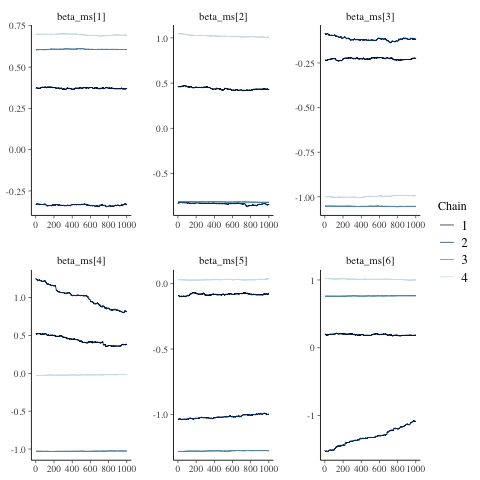

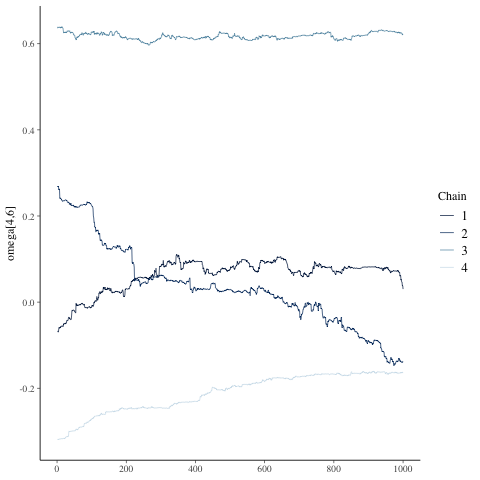

In [ ]:
%%R
# Let's have a look at convergence for the pre-fitted model 
# Plot the beta_ms samples to see if the chains converged
print(bayesplot::mcmc_trace(TwoStep_ITC_covar_fit$draws(),
           pars = vars(contains("_ms"))))
# Plot the inter-task correlation samples to see if the chains converged
print(bayesplot::mcmc_trace(TwoStep_ITC_covar_fit$draws(),
           pars = vars(contains("omega[4,6]"))))
# to do change to omega[4,7]

# Posterior distributions

We will now look at some common things you would want to know about the results of this model. So just like with any regression model, we want to know what the parameters are. The posterior distribution is the range of plausible parameters, and it's useful to know what the distribution looks like. To visualize it we make a histogram of the samples. It should be normal like a bell curve. When the model didn't converge the distribution will be discontinuous. Below we will use a function to plot the posteriors.

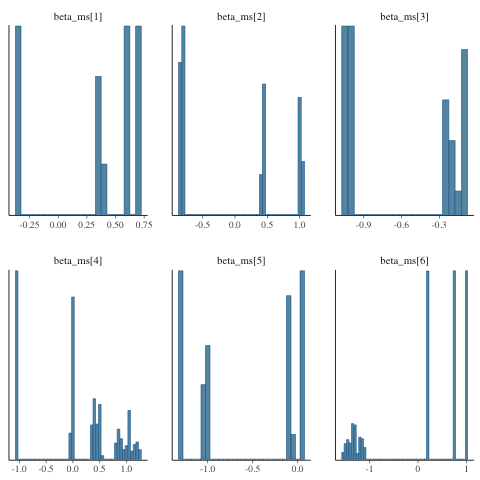

In [ ]:
%%R
# Plot the posterior distribution of some beta_ms
print(bayesplot::mcmc_hist(TwoStep_ITC_covar_fit$draws("beta_ms"),
                           binwidth = 0.05))

Below is code that plots posterior distributions manually from the samples data frame, and attaches the names of the parameters that we declared earlier. 

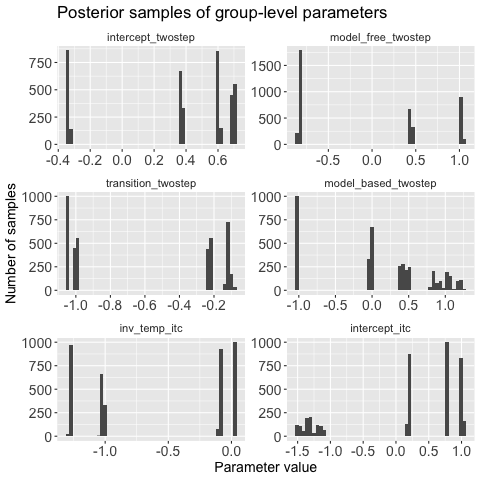

In [ ]:
%%R
# Get group posteriors, attach parameter names, and plot
get_param_group <- function(var_name, fit_vars){
  ind1 = which(strsplit(var_name, "")[[1]]=="[")
  ind2 = which(strsplit(var_name, "")[[1]]=="]")
  i = as.numeric(substring(var_name,ind1+1, ind2-1))
  var_name_new = fit_vars[i]
  return(var_name_new)
}
twostep_itc_fit_group <- TwoStep_ITC_covar_fit_draws_df %>%
  select(contains("_ms")) %>%
  pivot_longer(everything(),
               names_to = "param", 
               values_to = "params_val")

twostep_itc_fit_group <- within(twostep_itc_fit_group, 
       param_name <- get_param_group(param, 
                       twostep_itc_fit_vars))

twostep_itc_fit_group$param_name <- factor(twostep_itc_fit_group$param_name, 
                                              levels = twostep_itc_fit_vars)
print(ggplot(data = twostep_itc_fit_group) +
  geom_histogram(aes(params_val),
                 bins = 50) + 
  facet_wrap(~ param_name, scales = "free", ncol=2) + 
  labs(title = "group betas samples") + 
  theme(text = element_text(size = 14),
      axis.text = element_text(size = 14)) + 
  labs(title = "Posterior samples of group-level parameters",
       y = "Number of samples",
       x = "Parameter value") + 
  theme(text = element_text(size = 14),
        axis.text = element_text(size = 14),
        strip.background = element_rect(fill="white"),
        strip.text = element_text(colour="grey20")) + 
  scale_x_continuous(breaks=scales::pretty_breaks()))

# Hypothesis testing and summary statisitics

In this section you will compute the mean and 95% highest density interval. You can do hypothesis testing in this way. For example, you can check if a parameter is different fro zero by checking if the 95% highest density interval overlaps with zero. This is like doing a alpha = 0.05 p-value test. (Note this hypothesis would only make sense if your prior for the parameter was mean = 0, otherwise it's biased by the prior).

In [ ]:
%%R
# We can look at the average parameter values, and this function can compute
# other summary statistics as well  
# twostep_itc_fit_group <- summarise_draws(TwoStep_ITC_covar_fit$draws("beta_ms"), 
#                 "mean") %T>%
#                 print()
# to do get the 95% CI 
print(TwoStep_ITC_covar_fit$summary("beta_ms"))

# A tibble: 6 x 10
  variable      mean median    sd   mad     q5     q95  rhat ess_bulk ess_tail
  <chr>        <dbl>  <dbl> <dbl> <dbl>  <dbl>   <dbl> <dbl>    <dbl>    <dbl>
1 beta_ms[1]  0.335   0.492 0.405 0.241 -0.339  0.700   3.46     4.43       NA
2 beta_ms[2] -0.0479 -0.199 0.804 0.939 -0.842  1.03    4.14     4.29       NA
3 beta_ms[3] -0.598  -0.615 0.430 0.617 -1.05  -0.108   3.14     4.51       NA
4 beta_ms[4]  0.0977  0.170 0.749 0.728 -1.03   1.15    4.12     4.30       NA
5 beta_ms[5] -0.588  -0.546 0.571 0.794 -1.28   0.0330  3.61     4.39       NA
6 beta_ms[6]  0.163   0.487 0.906 0.610 -1.44   1.01    3.96     4.32       NA


Another example that does not apply to this dataset but could be of interest. If you are running a within-participants study would like to see if a parameter changed based on some condition (e.g. block type) then you can subtract the samples from the two posterior distributions and create a new ‘difference’ distribution. 
Then you can check if this ‘difference’ distribution is overlaps with zero. If not, you can conclude that the parameter changed (note that you would need to define a separate parameter in condition 1 and condition 2). There in an example of this in my recently published paper (LINK, page number). 

# Inter-task parameter correlation
Now it's time to check out the inter-task correaltion! We are going to inspect the correlation matrix parameter 'omega[4,7]' which reflects the correlation between the Two-step model-based parameter and the ITC discount k parameter. 

# Exercise 3
In the style of the code above, plot the posteriors for the correlation between model_free_twostep and discount_k_itc. Then get the summary for this parameter and see if the 95% highest density interval. Is the inter-task correlation credibly different from zero? 

In [ ]:
%%R
# Exercise 3 answer here

NULL


Awesome possum! Below is code that can visualize the whole correlation matrix which can be helpful to explore the inter-parameter relationships. Once again, this is code that I wrote which is not as convenient as the functions but works nonetheless. 

`summarise()` has grouped output by 'param1', 'param2', 'var1'. You can override using the `.groups` argument.


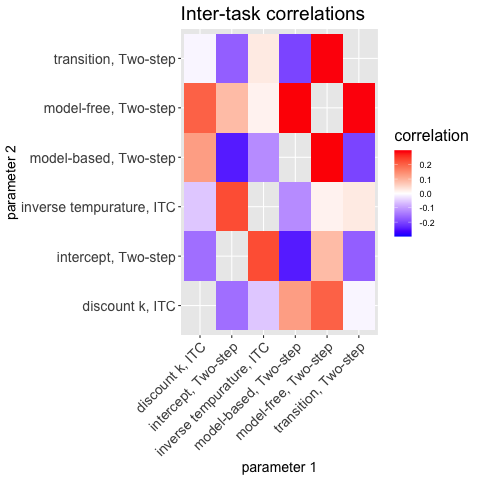

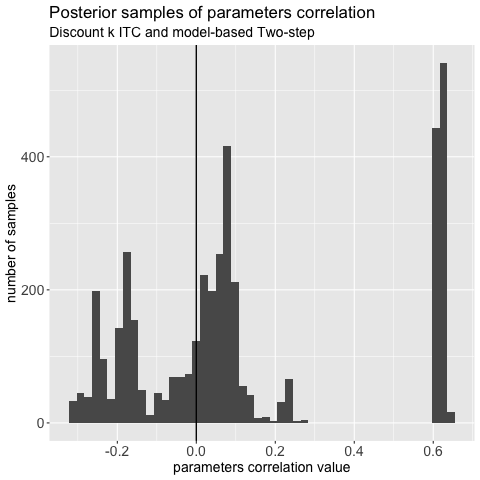

In [ ]:
%%R
# remove this is from the 6 parameter model  
twostep_itc_fit_vars <- c("intercept_twostep",
                          "model_free_twostep",
                          "transition_twostep",
                          "model_based_twostep",
                          "inv_temp_itc",
                          "discount_k_itc")
twostep_itc_fit_vars_titles <- c("intercept, Two-step",
                                 "model-free, Two-step",
                                 "transition, Two-step",
                                 "model-based, Two-step",
                                 "inverse tempurature, ITC",
                                 "discount k, ITC")
# remove
# Inspect the covariance matrix to find the inter-task correlations!
group_param_corr_fit <- list()
for (v in 1:length(twostep_itc_fit_vars)){
  for (vv in 1:length(twostep_itc_fit_vars)){
    if (v != vv){
         tmp_corr <- TwoStep_ITC_covar_fit_draws_df %>%
                    select(corr = paste0("omega[",v,",",vv,"]"),
                           covar = paste0("sigma[",v,",",vv,"]")) %>% 
                    mutate(param1 = twostep_itc_fit_vars[v],
                           param2 = twostep_itc_fit_vars[vv],
                           var1 = twostep_itc_fit_vars_titles[v],
                           var2 = twostep_itc_fit_vars_titles[vv])
         group_param_corr_fit <- bind_rows(group_param_corr_fit, tmp_corr)
    }
  }
}

group_param_corr <- group_param_corr_fit %>% 
  dplyr::group_by(param1, param2, var1, var2) %>%
  dplyr::summarise(mean = mean(corr, na.rm = TRUE),
            lower_95ci = quantile(corr, c(0.025,0.975))[1],
            upper_95ci = quantile(corr, c(0.025, 0.975))[2]) %>%
  ungroup() %>%
  dplyr::mutate(param1 = factor(param1, levels = twostep_itc_fit_vars),
         param2 = factor(param2, levels = twostep_itc_fit_vars))

# visualize the mean correlation matrix
print(ggplot(data = group_param_corr, 
       aes(x=var1, 
           y=var2, 
           fill=mean)) + 
  geom_tile() + 
    theme(title = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 14)) + 
  scale_fill_gradient2(low = "blue",
                       high = "red", 
                       mid = "white", 
                       midpoint = 0, 
                       limit = c(-0.3, 0.3),
                       space = "Lab", 
                       name="correlation",
                       na.value="red") + 
  labs(title = "Inter-task correlations",
       x = "parameter 1",
       y = "parameter 2"))

# plot correlations
print(ggplot(data = group_param_corr_fit %>%
         filter(param1 == "discount_k_itc" &  param2 == "model_based_twostep")) +
  geom_histogram(aes(corr), bins = 50) + 
  labs(title = "Posterior samples of parameters correlation",
       subtitle = "Discount k ITC and model-based Two-step",
       y = "number of samples",
       x = "parameters correlation value") + 
  geom_vline(aes(xintercept = 0)) + 
  theme(text = element_text(size = 14),
        axis.text = element_text(size = 14)) + 
  scale_x_continuous(breaks=scales::pretty_breaks()) + 
  geom_vline(xintercept = 0))

# Extract individual differences

This whole tutorial was about individual differences so let's grab them out of this model! Then you can use those parameters other analyses in whatever way you choose. Note that it is possible to add other measures into your hierarchal model (for example self-reports, or tests of group differences) but that won't be covered here, since I'm still learning how to do it! 😂

In [ ]:
%%R
# You can compute summary statistics like the mean per participant using summarise_draws function
twostep_itc_fit_betas <- summarise_draws(TwoStep_ITC_covar_fit$draws("beta_s"), 
                "mean") %T>%
                print()

# A tibble: 3,132 x 2
   variable        mean
   <chr>          <dbl>
 1 beta_s[1,1]  -0.510 
 2 beta_s[2,1]  -0.288 
 3 beta_s[3,1]  -0.171 
 4 beta_s[4,1]  -0.878 
 5 beta_s[5,1]   0.641 
 6 beta_s[6,1]  -0.368 
 7 beta_s[7,1]  -0.585 
 8 beta_s[8,1]   0.361 
 9 beta_s[9,1]   0.174 
10 beta_s[10,1]  0.0395
# … with 3,122 more rows


Below is some custom code to extract the worker_id and parameter name from the column 'variable'. Don't worry if you don't follow all the code, the goal is just for you to work with the output.

In [ ]:
%%R
get_param <- function(var_name, fit_vars){
  ind1 = which(strsplit(var_name, "")[[1]]==",")
  ind2 = which(strsplit(var_name, "")[[1]]=="]")
  xind = nchar(var_name)
  i = as.numeric(substring(var_name, xind-1, xind-1))
  var_name_new = as.character(fit_vars[i])
  return(var_name_new)
}

subs <- subs_all$worker_id

get_subID <- function(subj_row, subs){
  subID = subs[subj_row]
  return(subID)
}
twostep_itc_fit_subj1 <- within(twostep_itc_fit_betas, 
                                param_name <- get_param(variable,
                                                        twostep_itc_fit_vars))

twostep_itc_fit_subj2 <- twostep_itc_fit_subj1 %>%
        group_by(param_name) %>%
        mutate(subj_row = row_number())

twostep_itc_fit_subj <- within(twostep_itc_fit_subj2, 
                               worker_id <- get_subID(subj_row, subs)) %>%
    select(-variable,
           -subj_row) %>%
    pivot_wider(names_from = param_name,
                values_from = c(mean, -worker_id)) %T>%
  print()

# A tibble: 522 x 7
   worker_id intercept_twost… model_free_twos… transition_twos… model_based_two…
   <fct>                <dbl>            <dbl>            <dbl>            <dbl>
 1 s001               -0.510            0.140           -0.598             0.339
 2 s002               -0.288           -0.0246           0.753             0.350
 3 s003               -0.171            0.207           -0.277             0.261
 4 s004               -0.878           -0.259           -0.987             0.113
 5 s005                0.641            0.135            0.816             0.480
 6 s006               -0.368           -0.159           -0.550             0.407
 7 s007               -0.585           -0.635            0.0905            0.344
 8 s008                0.361           -0.0598           0.0845           -0.248
 9 s009                0.174            0.0796          -0.202            -0.994
10 s010                0.0395          -0.647           -0.498            -0.502
# … with

Now that we have the mean parameter estimate for each participant we could also write these to a .csv file for use in other analyses. Below we plot the distributions of the participants. We can also plot the relationship between the parameters, in the example below we plot the relationship of model-based and model-free paramters from the two-step task. **Of note, you can't use the correlation between these mean parameters in a statistical test.** This is because the parameters were selected based on the correlation parameter omega. It's no problem though just test the correlation using the methods followed above!

In [ ]:
%%R 
# histogram plot the per participant parameters 
print(ggplot(data = twostep_itc_fit_subj,
      aes(discount_k_itc)) + 
    geom_histogram())

print(ggplot(data = twostep_itc_fit_subj,
      aes(model_based_twostep)) + 
    geom_histogram())

print(ggplot(data = twostep_itc_fit_subj,
      aes(x = model_based_twostep,
          y = model_free_twostep)) + 
    geom_point() + 
    geom_smooth(method = "lm"))


NULL


# Exercise 4 
Make a scatter plot of the participant model-based versus discount k parameters.

In [ ]:
%%R
# Exercise 4 answer

NULL


Once you have a working model there are a number of things that would be prudent to do. 
One thing is to actually simulate data from the model and plot it and see that it fits the qualitative effects in the data. 
This type of exercise might help you to see ways that your model can be improved to capture some effects better. 
This loop iterating between behavior, models simulating behavior, and back is what turns the great wheel of science!

# Stretch Exercise 
You can also use this method to perform split half correlation. Make a new .stan file and edit it to fit separate parameters for the first and second half of the task, and the correlation between the parameters.

# The end! 

There’s so much to learn about this method and I hope that you have a better sense of what it means to run a STAN model. It can be very slow and frustrating, it is much more complicated than mixed-effects regression models (i.e. lme4 which does have the benefit of hierarchal analyses), but it also opens up a world of possibilities of custom models you can build that might better help understanding your data. Critically, to fit multiple tasks and models for the same participants in one model is not going to be feasible using only standard regression models. I am now in the field of Computational Psychiatry where correlations between measures (often symptoms and task behavior) are a major component of the research. I do hope to continue to use and expand on this methodology in that research context. 
<br>
If you enjoyed this tutorial, please follow the GitHub project and where applicable credit the tutorial, I exerted much mental effort creating it! Whatsmore, if this topic is near and dear to your heart, let's connect! You can follow my Github @laurabustamante and my Twitter @lauraabusta and email me at lauraab@princeton.edu
<br>

**References**
<br><br>
Daw, N. D., Gershman, S. J., Seymour, B., Dayan, P., & Dolan, R. J. (2011). Model-based influences on humans' choices and striatal prediction errors. Neuron, 69(6), 1204-1215.
<br><br>
Eisenberg, I. W., Bissett, P. G., Enkavi, A. Z., Li, J., MacKinnon, D. P., Marsch, L. A., & Poldrack, R. A. (2019). Uncovering the structure of self-regulation through data-driven ontology discovery. Nature communications, 10(1), 1-13.
<br><br>
Kirby, K. N., & Maraković, N. N. (1996). Delay-discounting probabilistic rewards: Rates decrease as amounts increase. Psychonomic bulletin & review, 3(1), 100-104.
<br><br>
Stan Development Team. 2021. Stan Modeling Language Users Guide and Reference Manual. https://mc-stan.org
<br><br>
Vehtari A., Gelman A., Simpson D., Carpenter B., & Bürkner P. C. (2020). Rank-normalization, folding, and localization: An improved Rhat for assessing convergence of MCMC. Bayesian Analysis.
<br><br>

